# Table of Contents

1. [**Dependencies**](#Dependencies)
2. [Neo-Euler orientations](#Neo-Euler-orientations)
3. [DBSCAN](#DBSCAN)
4. [**Clustered Ti Orientations**](#Clustered-Ti-Orientations)
5. [Symmetry Demonstration](#Symmetry-Demonstration)
6. [Clustering across fundamental region boundaries](#Clustering-across-fundamental-region-boundaries)
7. [**Clustered Ti misorientations**](#Clustered-Ti-misorientations)

Bold highlighted sections are the ones needed for the manuscript

# Dependencies

<div class="alert alert-info"><strong>Run this first!</strong></div>

In [1]:
%matplotlib inline

# Important external dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Other external dependencies
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook

# Local dependencies
from texpy.quaternion.orientation import Orientation, Misorientation
from texpy.quaternion.rotation import Rotation
from texpy.quaternion.symmetry import C1, D6h, D6, Oh
from texpy.quaternion.orientation_region import OrientationRegion
from texpy.vector.neo_euler import AxAngle
from texpy.vector import Vector3d
from texpy import plot

# Colorisation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb, to_hex
MPL_COLORS_RGB = [to_rgb('C{}'.format(i)) for i in range(10)]
MPL_COLORS_HEX = [to_hex(c) for c in MPL_COLORS_RGB]

# Animation
import matplotlib.animation as animation

# Visualisation
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.collections import CircleCollection
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rc('font', size=6)

# Neo-Euler orientations

In [2]:
# Load data from CTF file
dat = np.loadtxt('data/Ti_orientations.ctf', skiprows=1)[:, :3]
ori = Orientation.from_euler(np.radians(dat)).reshape(381, 507)[-100:, :200]

# Compute distance matrix
D = 2 * np.arccos(ori.dot_outer(ori).data)

# Get main clusters
dbscan = DBSCAN(0.05, 50, metric='precomputed').fit(D.reshape(ori.size, ori.size))
labels = dbscan.labels_.reshape(ori.shape)
print('Labels:', np.unique(labels))

Labels: [-1  0  1  2  3  4  5  6]


In [3]:
cluster_means = Orientation.stack([ori[labels == label].mean() for label in np.unique(labels)[1:]]).flatten()
cluster_means_axangle = AxAngle.from_rotation(cluster_means)
cluster_means_axangle_tuples = [tuple(cm) for cm in cluster_means_axangle.data]

In [5]:
cluster_means_axangle

AxAngle (7,)
[[-0.498   1.566  -0.4394]
 [-0.2578  1.3131 -2.1017]
 [-2.049   0.6918  0.1287]
 [-0.0563  1.2886 -2.2247]
 [ 0.3643  1.6187 -1.2893]
 [ 0.0028  1.9017 -0.7395]
 [-1.0407  1.8284 -1.3949]]

In [6]:
label_mask = np.logical_or(labels==0, labels==1)
labels_01 = np.zeros_like(labels, dtype='int') - 1
labels_01[label_mask] = labels[label_mask]
edgecolors = label2rgb(labels_01, colors=MPL_COLORS_RGB)
s = np.zeros_like(labels)
s[label_mask] = 15

In [7]:
vectors = cluster_means_axangle[:2]
delta = vectors[1] - vectors[0]

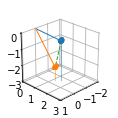

In [8]:
_, sample = ori.sample(5000, return_mask=True)


# Plot main figure
fig = plt.figure(figsize=(3.484252 * 0.5, 4 * 0.5))
# gs = plt.GridSpec(1, 1, fig, left=0, right=1)

ax = fig.add_subplot(111, projection='axangle', aspect='equal')
ax.scatter(ori[sample], facecolors=edgecolors[sample], edgecolor='none', linewidth=0, alpha=0.333, s=s[sample], cmap='viridis')
collection = Line3DCollection(
    [((cm[0], cm[1], -3), cm) for cm in cluster_means_axangle_tuples[:2]], 
    color=['C0', 'C1'], linewidths=0.5,
)
vector_lines = Line3DCollection(
    [
        ((0, 0, 0), vectors.data[0]),
        ((0, 0, 0), vectors.data[1]),
        (vectors.data[0], vectors.data[0] + delta.data[0]),
    ],
    color=['C0', 'C1', 'C2'],
    linestyles=['solid', 'solid', 'dashed'],
    linewidths=1,
)

ax.add_collection3d(collection)
ax.add_collection3d(vector_lines)

ax.set_xticks([-2, -1, 0, 1])
ax.set_yticks([0, 1, 2, 3])
ax.set_zticks([-3, -2, -1, 0])
ax.tick_params(pad=-3)


ax.set_xlim(-2, 1)
ax.set_ylim(0, 3)
ax.set_zlim(-3, 0)
ax.view_init(25, 45)

# ax.grid(False)
ax.xaxis.set_pane_color((1, 1, 1))
ax.yaxis.set_pane_color((1, 1, 1))
ax.zaxis.set_pane_color((1, 1, 1))

# ax.text3D(-.5, 0, 0, 'Origin (identity)', zdir='x')

# The fix
for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout()
fig.savefig('./axangles-data.png', dpi=1200, transparent=True)

In [9]:
MPL_COLORS_HEX

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [10]:
# Generate animation
def animate(angle):
    ax.view_init(15, angle)
    plt.draw()
ani = animation.FuncAnimation(fig, animate, np.linspace(75, 360+74, 720), interval=25)
fig.show()

/home/hremadmin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [11]:
# Save animation
Writer = animation.writers['ffmpeg']

writer = Writer(fps=30, metadata=dict(artist='bm424@cam.ac.uk'), bitrate=1800)

ani.save('Ti-orientations.mp4', writer=writer, dpi=300)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

# DBSCAN

for interactive poster only

In [ ]:
# Prepare data
N = 40
std = 0.8
dat, labels = make_blobs(N, centers=[(-2, 0), (2, 0)], cluster_std=std)

In [ ]:
# Calculate clusters and labels
dbscan = DBSCAN(eps=0.6, min_samples=3).fit(dat)
print(np.unique(dbscan.labels_))
c = label2rgb(dbscan.labels_, colors=[to_rgb('C0'), to_rgb('C1')])

In [ ]:
# Separate core and border
core_mask = np.zeros(N, dtype=bool)
core_mask[dbscan.core_sample_indices_] = True


In [ ]:
# Plot image
ax = plt.figure(figsize=(18, 9)).add_subplot(111, aspect='equal')
ax.scatter(dat[core_mask, 0], dat[core_mask, 1], c=c[core_mask], edgecolor='none', s=400)
ax.scatter(dat[~core_mask, 0], dat[~core_mask, 1], c=c[~core_mask], edgecolor='none', s=50)

circles = [Circle((x, y), radius=0.8, color='lightgray', alpha=0.1) for x, y in dat]
for circle in circles:
    ax.add_patch(circle)
    
ax.set_xlim(-6, 6)
ax.set_ylim(-3, 3)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('DBSCAN-demo.png', dpi=300, transparent=True)

# Clustered Ti Orientations

In [13]:
# Load data from CTF file
dat = np.loadtxt('./data/Ti_orientations.ctf', skiprows=1)[:, :3]

In [14]:
ori = Orientation.from_euler(np.radians(dat)).reshape(381, 507)[-100:, :200]
fundamental_region = OrientationRegion.from_symmetry(D6)

print('Number of orientations:', ori.size)

Number of orientations: 20000


## Naive approach, no symmetry

Not really needed, for interest as contrast

In [ ]:
# Compute distance matrix
D = 2 * np.arccos(ori.dot_outer(ori).data)

## Correct approach, with symmetry

**Option 1: quick, will wreck your RAM**

Computes every possibility in a single tensor, then minimises.

In [ ]:
# Compute misorientations
confirm = input('Are you sure? (y/n) ')
if confirm == 'y':
    misori_equiv = D6.outer(~ori).outer(ori).outer(D6)
    D = misori_equiv.angle.data.min(axis=(0, 2))

**Option 2: medium-speed, should be OK for RAM**

Precomputes one set of equivalent orientations.

In [ ]:
D = np.zeros(ori.shape + ori.shape)
D.fill(np.infty)

OS2 = ori.outer(D6)

for i in tqdm_notebook(range(ori.size)):
    idx = np.unravel_index(i, ori.shape)
    o_1 = ori[idx]
    misori = D6.outer(~o_1).outer(OS2)
    d = misori.angle.data.min(axis=(0, -1))
    D[idx[0], idx[1], ...] = np.minimum(D[idx[0], idx[1], ...], d)

**Option 3: slow, safe for RAM**

Iterates through every pair of orientations.

In [ ]:
from itertools import combinations_with_replacement as icombinations
D = np.empty(ori.shape + ori.shape)

for i, j in tqdm_notebook(list(icombinations(range(ori.size), 2))):
    idx_1, idx_2 = np.unravel_index(i, ori.shape), np.unravel_index(i, ori.shape)
    o_1, o_2 = ori[idx_1], ori[idx_2]
    misori = D6.outer(~o_1).outer(o_2).outer(D6)
    d = misori.angle.data.min(axis=(0, 3))
    D[idx_1[0], idx_1[1], idx_2[0], idx_2[1]] = d
    D[idx_2[0], idx_2[1], idx_1[0], idx_1[1]] = d

**Here's one I made earlier** (won't save to dropbox, lmk if you want it)

In [15]:
D = np.load('./ori-distance((100, 200)).npy')

FileNotFoundError: [Errno 2] No such file or directory: './ori-distance((100, 200)).npy'

## Clustering

In [ ]:
# Get main clusters
dbscan = DBSCAN(0.05, 40, metric='precomputed').fit(D.reshape(ori.size, ori.size))
print('Labels:', np.unique(dbscan.labels_))
labels = dbscan.labels_.reshape(ori.shape)
n_clusters = len(np.unique(dbscan.labels_)) - 1
print('Number of clusters:', n_clusters)

In [ ]:
cluster_means = Orientation.stack([ori[labels == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means = cluster_means.set_symmetry(D6)

In [ ]:
cluster_means.axis

In [ ]:
# Recenter based on the matrix cluster and recompute means
ori_recentered = (~cluster_means[0]) * ori
ori_recentered = ori_recentered.set_symmetry(D6)
cluster_means_recentered = Orientation.stack([ori_recentered[labels == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means_axangle = AxAngle.from_rotation(cluster_means_recentered)

In [ ]:
cluster_means_recentered.axis

## Plotting

In [ ]:
%matplotlib qt5
fig = plt.figure(figsize=(3.484252, 6.5))
ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho')
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)

In [ ]:
# get label colors
colors = [to_rgb('C{}'.format(i)) for i in range(10)]
labels_rgb = label2rgb(labels, colors=colors)

# Create map and lines pointing to cluster means
mapping = labels_rgb
collection = Line3DCollection([((0, 0, 0), tuple(cm)) for cm in cluster_means_axangle.data], colors=colors)

In [ ]:
# Main plot
fig = plt.figure(figsize=(3.484252, 3.484252))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho')
ax_ori.scatter(ori_recentered, c=labels_rgb.reshape(-1, 3), s=1)
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
ax_ori.add_collection3d(collection)

ax_ori.set_axis_off()
ax_ori.set_xlim(-1, 1)
ax_ori.set_ylim(-1, 1)
ax_ori.set_zlim(-1, 1)
ax_ori.view_init(90, -30)

# Legend
handles = [
    Line2D(
        [0], [0], 
        marker='o', color='none', 
        label=i+1, 
        markerfacecolor=color, markersize=5
    ) for i, color in enumerate(colors[:n_clusters])
]

ax_ori.legend(handles=handles, loc='lower right', ncol=2, numpoints=1, labelspacing=0.15, columnspacing=0.15, handletextpad=0.05)
fig.savefig('./clustered-orientations-top-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252 * 2, 1.5 * 2))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho', aspect='equal')
ax_ori.scatter(ori_recentered, c=labels_rgb.reshape(-1, 3), s=1)
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
# ax_ori.add_collection3d(collection)

ax_ori.set_axis_off()
ax_ori.set_xlim(-1, 1)
ax_ori.set_ylim(-1, 1)
ax_ori.set_zlim(-1, 1)
ax_ori.view_init(0, -30)
fig.savefig('./clustered-orientations-side-data.png', transparent=True, dpi=900)

In [ ]:
ax_mapping = fig.add_subplot(gridspec[2])
ax_mapping.imshow(mapping)

ax_mapping.set_xticks([])
ax_mapping.set_yticks([])

fig.savefig('./clustered-orientations-data.png', transparent=True, dpi=600)

# Symmetry Demonstration

### No symmetry (random points)

In [ ]:
# Set up non-symmetric object
np.random.seed(10)
dat = np.random.random((8, 3))
dat -= np.mean(dat)
verts = Vector3d(dat)
rot = Rotation.identity()
fr = OrientationRegion.from_symmetry(C1)

# Initial plot object
hull = ConvexHull(verts.data)
collection = Poly3DCollection([verts.data[s] for s in hull.simplices], edgecolors='black', facecolors=(0.122, 0.467, 0.706, 0.5))
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(121, projection='3d', proj_type = 'ortho', aspect='equal')
ax1.plot((0, 0), (0, 0), (-5, 5), 'k-')
ax1.add_collection3d(collection)
ax1.set_xlim(-0.5, 0.5)
ax1.set_ylim(-0.5, 0.5)
ax1.set_zlim(-0.5, 0.5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_axis_off()
ax1.view_init(15, 0)

# Initial plot axangle
ax2 = fig.add_subplot(122, projection='axangle', aspect='equal')
scatter = ax2.scatter(rot, s=200, c='C0')
ax2.plot_wireframe(fr, color='lightgray', linewidth=0.5, alpha=0.75)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_axis_off()
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_zlim(-2, 2)

plt.tight_layout()

# Animate
def animate(angle):
    rot = Rotation.from_neo_euler(AxAngle.from_axes_angles((0, 0, 1), angle))
    verts_new = rot * verts
    scatter._offsets3d = tuple(AxAngle.from_rotation(rot).xyz)
    collection.set_verts([verts_new.data[s] for s in hull.simplices])
ani = animation.FuncAnimation(fig, animate, np.radians(np.linspace(0, 359, 720)), interval=25)
fig.show()

In [ ]:
# Save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('symmetry-demo-C1.mp4', writer=writer, dpi=300)

### Cubic symmetry

In [ ]:
dat = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 1, 1],
], dtype=float)
faces = np.array([
    [0, 1, 2, 3],
    [0, 1, 5, 4],
    [0, 3, 7, 4],
    [4, 5, 6, 7],
    [1, 2, 6, 5],
    [2, 3, 7, 6],
])

dat -= np.mean(dat)
verts = Vector3d(dat)
rot = Rotation.identity()
fr_0 = OrientationRegion.from_symmetry(C1)
fr = OrientationRegion.from_symmetry(Oh)

collection = Poly3DCollection([verts.data[f] for f in faces], edgecolors='black', facecolors=(1., 0.498, 0.055, 0.5))


fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(121, projection='3d', proj_type='ortho', aspect='equal')
ax1.plot((0, 0), (0, 0), (-5, 5), 'k-')
ax1.add_collection3d(collection)
ax1.set_xlim(-0.5, 0.5)
ax1.set_ylim(-0.5, 0.5)
ax1.set_zlim(-0.5, 0.5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_axis_off()
ax1.view_init(15, 0)


ax2 = fig.add_subplot(122, projection='axangle', aspect='equal')
scatter_0 = ax2.scatter(rot, s=200, c='C0')
scatter = ax2.scatter(rot, s=200, c='C1')
ax2.plot_wireframe(fr_0, color='lightgray', linewidth=0.5, alpha=0.5)
ax2.plot_wireframe(fr, color='lightgray', linewidth=0.5, alpha=0.5)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_axis_off()
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_zlim(-2, 2)

plt.tight_layout()

def animate(angle):
    rot_0 = Orientation.from_neo_euler(AxAngle.from_axes_angles((0, 0, 1), angle))
    rot = rot_0.set_symmetry(Oh)
    verts_new = rot_0 * verts
    scatter_0._offsets3d = tuple(AxAngle.from_rotation(rot_0).xyz)
    scatter._offsets3d = tuple(AxAngle.from_rotation(rot).xyz)
    collection.set_verts([verts_new.data[f] for f in faces])
ani = animation.FuncAnimation(fig, animate, np.radians(np.linspace(0, 359.5, 720)), interval=200)
fig.show()

In [ ]:
# Save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('symmetry-demo-Oh.mp4', writer=writer, dpi=300)

# Clustering across fundamental region boundaries

In [ ]:
# Set up data
d1 = Orientation.random_vonmises(50, alpha=50)
d2_0 = Rotation.from_neo_euler(AxAngle.from_axes_angles((1, 0, 0), np.pi/4))
d2 = Orientation.random_vonmises(50, alpha=50, reference=d2_0)
d3_0 = Rotation.from_neo_euler(AxAngle.from_axes_angles((1, 1, 0), np.pi/3))
d3 = Orientation.random_vonmises(50, alpha=50, reference=d3_0)
dat = Orientation.stack([d1, d2, d3]).flatten().set_symmetry(Oh)

fr = OrientationRegion.from_symmetry(Oh)

# Naive cluster
D = (~dat).outer(dat).angle.data
dbscan_naive = DBSCAN(0.3, 10, metric='precomputed').fit(D)
print('Labels:', np.unique(dbscan_naive.labels_))

# Cluster
D = Misorientation((~dat).outer(dat)).set_symmetry((Oh, Oh)).angle.data
dbscan = DBSCAN(0.3, 20, metric='precomputed').fit(D)
print('Labels:', np.unique(dbscan.labels_))

# Generate colors
colors = [to_rgb('C{}'.format(i)) for i in range(10)]  # ['C0', 'C1', ...]
c = label2rgb(dbscan.labels_, colors=colors)
c_naive = label2rgb(dbscan_naive.labels_, colors=colors)

In [ ]:
# Figure
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(121, projection='axangle', aspect='equal')
ax1.scatter(dat, c=c_naive)
ax1.plot_wireframe(fr, color='gray', alpha=0.5, linewidth=0.5, rcount=30, ccount=30)
ax1.set_axis_off()

ax1.set_xlim(-0.8, 0.8)
ax1.set_ylim(-0.8, 0.8)
ax1.set_zlim(-0.8, 0.8)

ax2 = fig.add_subplot(122, projection='axangle', aspect='equal')
ax2.scatter(dat, c=c)
ax2.plot_wireframe(fr, color='gray', alpha=0.5, linewidth=0.5, rcount=30, ccount=30)
ax2.set_axis_off()

ax2.set_xlim(-0.8, 0.8)
ax2.set_ylim(-0.8, 0.8)
ax2.set_zlim(-0.8, 0.8)

plt.tight_layout()

# Generate animation
def animate(angle):
    ax1.view_init(15, angle)
    ax2.view_init(15, angle)
    plt.draw()
ani = animation.FuncAnimation(fig, animate, np.linspace(75, 360+74, 720), interval=25)

In [ ]:
# Save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('clustering-fr-demo.mp4', writer=writer, dpi=300)

# Clustered Ti misorientations

In [ ]:
# Load data from CTF file
dat = np.loadtxt('/home/bm424/Desktop/upload_scripts_apollo/Ti_orientations.ctf', skiprows=1)[:, :3]

ori = Orientation.from_euler(np.radians(dat)).reshape(381, 507)[-100:, :200].set_symmetry(D6)

fundamental_region = OrientationRegion.from_symmetry(D6, D6)

# Compute misorientations
misori_base = Misorientation(~ori[:, :-1] * ori[:, 1:])
boundary_mask = misori_base.angle > np.radians(7)
misori = misori_base[boundary_mask].set_symmetry(D6, D6)
print('Number of misorientations:', misori.size)

In [ ]:
small_mask = misori.angle < np.radians(7)

## Compute D-matrix

**The RAM-wrecking option**

In [ ]:
mismisori = (~misori).outer(misori)
mismisori_equiv = D6.outer(~misori).outer(D6).outer(D6).outer(misori).outer(D6)
distance = mismisori_equiv.angle.data.min(axis=(0, 2, 3, 5))

**The slow-but-sane option** (about 20 mins)

In [ ]:
from itertools import combinations_with_replacement as icombinations
from tqdm import tqdm_notebook
distance = np.empty((misori.size, misori.size))

for i, j in tqdm_notebook(list(icombinations(range(misori.size), 2))):
    m_1, m_2 = misori[i], misori[j]
    mismisori = D6.outer(~m_1).outer(D6).outer(D6).outer(m_2).outer(D6)
    d = mismisori.angle.data.min(axis=(0, 2, 3, 5))
    distance[i, j] = d
    distance[j, i] = d

In [ ]:
np.save('./misori-distance((300, 500)).npy', distance)

**The priori incantatem option**

In [ ]:
distance = np.load('./misori-distance((100, 200)).npy')

## Clusters

In [ ]:
distance = distance[~small_mask][:, ~small_mask]

In [ ]:
# Compute clusters
dbscan = DBSCAN(0.05, 10, metric='precomputed').fit(distance)
print('Cluster labels:', np.unique(dbscan.labels_))
n_clusters = len(np.unique(dbscan.labels_)) - 1
print('Number of clusters:', n_clusters)

# Generate colors
colors = [to_rgb('C{}'.format(i)) for i in range(10)]  # ['C0', 'C1', ...]
c = label2rgb(dbscan.labels_, colors=colors)

In [ ]:
misori = misori[~small_mask]

In [ ]:
cluster_means = Misorientation.stack([misori[dbscan.labels_ == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means = cluster_means.set_symmetry(D6, D6)

In [ ]:
np.degrees(cluster_means.angle.data)

In [ ]:
# Generate map
mapping = np.ones(misori_base.shape + (3,))

mapping[np.where(boundary_mask)[0][~small_mask], np.where(boundary_mask)[1][~small_mask]] = c

## Plot

In [ ]:
# Plot clustered misorientations
fig = plt.figure(figsize=(3.484252, 3.484252))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)


ax_misori = fig.add_subplot(gridspec[0], projection='axangle', aspect='equal', proj_type='ortho')
ax_misori.scatter(misori, c=c, s=4, edgecolor='none')
ax_misori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=361, ccount=361)

ax_misori.set_axis_off()
ax_misori.set_xlim(0.2, 1.2)
ax_misori.set_ylim(-.1, .9)
ax_misori.set_zlim(-0, 1)
ax_misori.view_init(90, -60)


handles = [
    Line2D(
        [0], [0], 
        marker='o', color='none', 
        label=i+1, 
        markerfacecolor=color, markersize=5
    ) for i, color in enumerate(colors[:n_clusters])
]

ax_misori.legend(handles=handles, loc='upper center')

fig.savefig('./clustered-misorientations-top-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252*2, 1.5*2))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_misori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho', aspect='equal')
ax_misori.scatter(misori, c=c, s=4, edgecolor='none')
ax_misori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)

ax_misori.set_axis_off()
ax_misori.set_xlim(0.1, 1.1)
ax_misori.set_ylim(0.1, 1.1)
ax_misori.set_zlim(-0, 1)
ax_misori.view_init(0, -60)


fig.savefig('./clustered-misorientations-side-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252, 2))

gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)
ax_mapping = fig.add_subplot(gridspec[0])
ax_mapping.imshow(mapping)

ax_mapping.set_xticks([])
ax_mapping.set_yticks([])

fig.savefig('./clustered-misorientations-mapping-data.png', transparent=True, dpi=600)